# Classification. Binomial logistic regression model

Set up spark context and SparkSession

In [33]:
try:
    sc.stop
except:
    pass

from pyspark import SparkContext , SparkConf
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sparkContext = sc)

Load dataset

In [34]:
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .options(delimiter=';')\
            .load("./data/bank.csv",header=True);
df.drop('day','month','poutcome').show(5)


+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular|      79|       1|   -1|       0| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular|     220|       1|  339|       4| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|   -1|       0| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|     226|       1|   -1|       0| no|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
o

In [35]:
df.cache()

df.printSchema()
df.select('y').show(5)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)

+---+
|  y|
+---+
| no|
| no|
| no|
| no|
| no|
+---+
only showing top 5 rows



Deal with categorical data and Convert the data to dense vector

In [36]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')


In [37]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome']

num_cols = ['balance', 'duration','campaign','pdays','previous',]
labelCol = 'y'

data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[8,11,15,16,1...|   no|
|(29,[4,11,13,16,1...|   no|
|(29,[0,12,14,16,1...|   no|
|(29,[0,11,14,16,1...|   no|
|(29,[1,11,13,16,1...|   no|
+--------------------+-----+
only showing top 5 rows



Deal with Categorical Label and Variables

In [38]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(20, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[8,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[0,11,14,16,1...|   no|         0.0|
|(29,[1,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[6,11,14,16,1...|   no|         0.0|
|(29,[2,11,13,16,1...|   no|         0.0|
|(29,[7,11,14,16,1...|   no|         0.0|
|(29,[4,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[3,11,13,16,1...|   no|         0.0|
|(29,[2,11,14,16,1...|   no|         0.0|
|(29,[10,12,13,16,...|  yes|         1.0|
|(29,[1,11,13,16,1...|   no|         0.0|
|(29,[0,11,14,16,1...|   no|         0.0|
|(29,[2,11,13,16,1...|   no|         0.0|
|(29,[3,12,14,16,1...|   no|         0.0|
|(29,[1,12,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
+--------------------+-----+------

In [39]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(29,[8,11,15,16,1...|   no|(29,[8,11,15,16,1...|
|(29,[4,11,13,16,1...|   no|(29,[4,11,13,16,1...|
|(29,[0,12,14,16,1...|   no|(29,[0,12,14,16,1...|
|(29,[0,11,14,16,1...|   no|(29,[0,11,14,16,1...|
|(29,[1,11,13,16,1...|   no|(29,[1,11,13,16,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



Split the data to training and test data sets

In [40]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |label|
+------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-588.0,81.0,4.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-105.0,60.0,2.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,104.0,3.0,-1.0]) |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,238.0,808.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,466.0,164.0,1.0,-1.0])|no   |
+------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+-----------------------------

##  Binomial logistic regression

In [41]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')



Convert indexed labels back to original labels.


In [42]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline

In [43]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

Train model.  This also runs the indexers.

In [44]:
model = pipeline.fit(trainingData)

Make predictions.

In [45]:
predictions = model.transform(testData)

Select example rows to display.

In [46]:
predictions.show(5)

+--------------------+-----+------------+--------------------+--------------------+--------------------+----------+--------------+
|            features|label|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+-----+------------+--------------------+--------------------+--------------------+----------+--------------+
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[1.00646925039171...|[0.73232860761819...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[2.98869150651624...|[0.95206062426158...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[3.22769490427613...|[0.96186328666941...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[3.02945697056648...|[0.95388729297981...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[0.71897534214788...|

# Evaluation

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0987654


In [16]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lrModel.setThreshold(bestThreshold)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.005363036303630363|0.044444444444444446|
|0.008663366336633664| 0.10476190476190476|
|0.011963696369636964| 0.16507936507936508|
|0.014438943894389438| 0.23174603174603176|
|0.018151815181518153| 0.28888888888888886|
| 0.02268976897689769|  0.3396825396825397|
|0.028877887788778877| 0.37777777777777777|
| 0.03424092409240924|  0.4222222222222222|
|0.041254125412541254| 0.45396825396825397|
| 0.04661716171617162|  0.4984126984126984|
|0.055693069306930694|  0.5142857142857142|
| 0.06229372937293729|  0.5492063492063493|
| 0.06930693069306931|   0.580952380952381|
| 0.07466996699669967|  0.6253968253968254|
| 0.08292079207920793|  0.6476190476190476|
|   0.091996699669967|  0.6634920634920635|
| 0.10107260726072607|  0.6793650793650794|
| 0.11138613861386139|  0.6857142857142857|
| 0.12004950495049505|  0.704761

LogisticRegressionModel: uid=LogisticRegression_baa19d64a21c, numClasses=2, numFeatures=29

visualization

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['no', 'yes']

In [19]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[1547,   29],
       [ 147,   59]])

Confusion matrix, without normalization
[[1547   29]
 [ 147   59]]


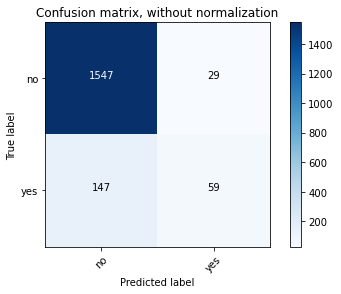

In [20]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.98159898 0.01840102]
 [0.71359223 0.28640777]]


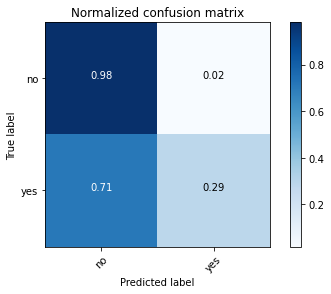

In [21]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()